# import tensorflow as tf
import os
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

In [2]:
# Function to preprocess TIFF images
def preprocess_tiff(image_path, target_size):
    with rasterio.open(image_path) as src:
        red_band = src.read(4)  # Band 4
        green_band = src.read(3)  # Band 3
        blue_band = src.read(2)  # Band 2
        rgb_image = np.dstack((red_band, green_band, blue_band))
        rgb_image = cv2.resize(rgb_image, target_size, interpolation=cv2.INTER_CUBIC)
        rgb_image = np.clip(rgb_image, 0, 255) / 255.0  # Normalize to 0 to 1
    return rgb_image

In [3]:
# Function to load and preprocess standard images
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} does not exist.")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image {image_path}.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to 0 to 1
    return image

In [4]:
def split_image(image, size=(527, 527)):
    h, w = image.shape[:2]
    split_images = []
    for i in range(0, h, size[0]):
        for j in range(0, w, size[1]):
            split_img = image[i:i + size[0], j:j + size[1]]
            split_images.append(split_img)
    return split_images

def preprocess_image(hr_file, lr_dir, hr_dir, lc_dir, target_size=(1054, 1054)):
    hr_image_path = os.path.join(hr_dir, hr_file)
    base_name = hr_file.replace('_rgb.png', '')
    
    hr_image = load_image(hr_image_path)
    lr_image_file = f"{base_name}-L2A_data.tiff"
    lr_image_path = os.path.join(lr_dir, lr_image_file)
    lr_image = preprocess_tiff(lr_image_path, target_size)
    
    lc_image_file = f"{base_name}.tif"
    lc_image_path = os.path.join(lc_dir, lc_image_file)
    with rasterio.open(lc_image_path) as src:
        lc_band = src.read(1)
        lc_band = cv2.resize(lc_band, target_size, interpolation=cv2.INTER_CUBIC)
        lc_band = np.expand_dims(lc_band, axis=-1)
        lc_band = np.clip(lc_band, 0, 255) / 255.0
    
    lr_image = np.clip(lr_image, 0, 1)
    hr_image = np.concatenate((hr_image, lc_band), axis=-1)
    lr_image = np.concatenate((lr_image, lc_band), axis=-1)
    
    hr_splits = split_image(hr_image, (527, 527))
    lr_splits = split_image(lr_image, (527, 527))
    
    return hr_splits, lr_splits

def create_dataset(lr_dir, hr_dir, lc_dir, target_size=(1054, 1054)):
    hr_image_files = [f for f in os.listdir(hr_dir) if f.endswith('_rgb.png') and not f.startswith('.')]
    hr_images = []
    lr_images = []

    for hr_file in hr_image_files:
        hr_splits, lr_splits = preprocess_image(hr_file, lr_dir, hr_dir, lc_dir, target_size)
        hr_images.extend(hr_splits)
        lr_images.extend(lr_splits)

    return np.array(hr_images), np.array(lr_images)

In [5]:
# Paths to directories
hr_dir = 'high_resolution_final'
lr_dir = 'low_resolution_final'
lc_dir = 'land_cover_final'

hr_images, lr_images = create_dataset(lr_dir, hr_dir, lc_dir, target_size=(1054, 1054))

In [6]:
# Get the size of the numpy arrays in bytes
hr_images_size_bytes = hr_images.nbytes
lr_images_size_bytes = lr_images.nbytes

# Convert sizes to MB for readability
hr_images_size_mb = hr_images_size_bytes / (1024 * 1024)
lr_images_size_mb = lr_images_size_bytes / (1024 * 1024)

# Convert sizes to GB for readability
hr_images_size_gb = hr_images_size_mb / 1024
lr_images_size_gb = lr_images_size_mb / 1024

print(f"High-resolution images array size: {hr_images_size_gb:.2f} GB")
print(f"Low-resolution images array size: {lr_images_size_gb:.2f} GB")

High-resolution images array size: 71.51 GB
Low-resolution images array size: 35.76 GB


In [7]:
# Function to check data
def check_data(hr_images, lr_images):
    for i in range(min(4, len(hr_images))):
        hr_image = hr_images[i]
        lr_image = lr_images[i]
        
        print(f"High-resolution image {i}: shape={hr_image.shape}, min={hr_image.min()}, max={hr_image.max()}")
        print(f"Low-resolution image {i}: shape={lr_image.shape}, min={lr_image.min()}, max={lr_image.max()}")
        print("")

# Check data
check_data(hr_images, lr_images)

High-resolution image 0: shape=(527, 527, 4), min=0.0, max=0.8862745098039215
Low-resolution image 0: shape=(527, 527, 4), min=0.0004166900471318513, max=0.002142509911209345

High-resolution image 1: shape=(527, 527, 4), min=0.0, max=1.0
Low-resolution image 1: shape=(527, 527, 4), min=0.0003948086523450911, max=0.002181642223149538

High-resolution image 2: shape=(527, 527, 4), min=0.0, max=0.8549019607843137
Low-resolution image 2: shape=(527, 527, 4), min=0.00039544026367366314, max=0.0021710461005568504

High-resolution image 3: shape=(527, 527, 4), min=0.0, max=0.8941176470588236
Low-resolution image 3: shape=(527, 527, 4), min=0.0004146687570028007, max=0.0021474184468388557



In [8]:
train_hr_images, test_hr_images, train_lr_images, test_lr_images = train_test_split(hr_images, lr_images, test_size=0.2, random_state=42)

In [12]:
# Generator class for training data
class DataGenerator(Sequence):
    def __init__(self, lr_images, hr_images, batch_size=8, target_size=(1054, 1054)):
        self.lr_images = lr_images
        self.hr_images = hr_images
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.lr_images))
        
    def __len__(self):
        return int(np.floor(len(self.lr_images) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        lr_batch = np.array([self.lr_images[i] for i in indices])
        hr_batch = np.array([self.hr_images[i] for i in indices])
        return lr_batch, hr_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)
    
    def get_info(self):
        info = {
            'num_samples': len(self.lr_images),
            'batch_size': self.batch_size,
            'num_batches': self.__len__(),
            'image_shape': self.lr_images[0].shape if len(self.lr_images) > 0 else None,
        }
        return info

In [13]:
train_generator = DataGenerator(train_lr_images, train_hr_images, batch_size=8)
test_generator = DataGenerator(test_lr_images, test_hr_images, batch_size=8)

In [23]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(1, 1, input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1, 1, 1, input_shape[-1]), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        attention = K.tanh(K.conv2d(x, self.W) + self.b)
        attention_weights = K.softmax(attention, axis=-1)
        context_vector = attention_weights * x
        return context_vector


In [24]:
def create_model_with_attention(input_shape=(527, 527, 4)):  # 4 channels: RGB + landcover band
    inputs = Input(shape=input_shape)
    attention = AttentionLayer()(inputs)
    
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(attention)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    outputs = Conv2D(4, (5, 5), activation='linear', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', psnr_metric, ssim_metric])
    return model

# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

model = create_model_with_attention()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 527, 527, 4)]     0         
                                                                 
 attention_layer_4 (Attentio  (None, 527, 527, 4)      20        
 nLayer)                                                         
                                                                 
 conv2d_2 (Conv2D)           (None, 527, 527, 64)      20800     
                                                                 
 conv2d_3 (Conv2D)           (None, 527, 527, 32)      2080      
                                                                 
 conv2d_4 (Conv2D)           (None, 527, 527, 4)       3204      
                                                                 
Total params: 26,104
Trainable params: 26,104
Non-trainable params: 0
_________________________________________________________

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_with_attention.h5', save_best_only=True, monitor='val_loss')

In [27]:
history = model.fit(train_generator, epochs=1, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

loss, mse, psnr, ssim = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test MSE: {mse}, Test PSNR: {psnr}, Test SSIM: {ssim}")

model.save('srcnn_model_with_attention.h5')

216/216 [==============================] - 799s 4s/step - loss: 0.0153 - mse: 0.0153 - psnr_metric: 20.9166 - ssim_metric: 0.6414
Test Loss: 0.015320874750614166, Test MSE: 0.015320922248065472, Test PSNR: 20.9166259765625, Test SSIM: 0.6413587927818298


Loading low-resolution image from low_resolution_final/Landcover-1000781-L2A_data.tiff
Loading land cover image from land_cover_final/Landcover-1000781.tif


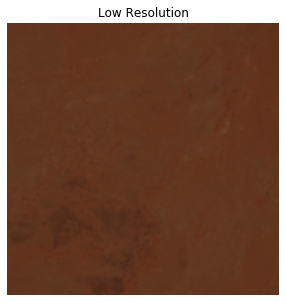

Loading low-resolution image from low_resolution_final/Landcover-1000781-L2A_data.tiff
Loading land cover image from land_cover_final/Landcover-1000781.tif
1/1 [==============================] - 0s 205ms/step
Loading high-resolution image from high_resolution_final/Landcover-1000781_rgb.png
High-resolution image shape: (1054, 1054, 3)


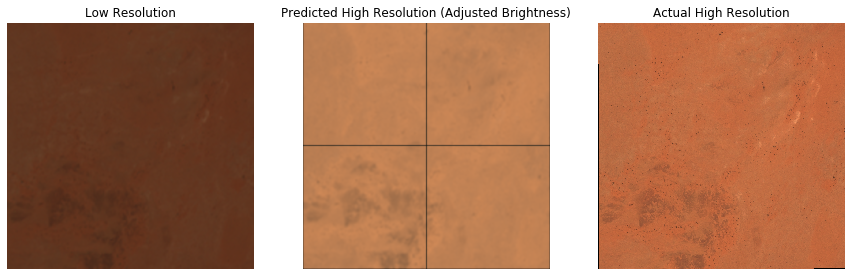

In [44]:
import os
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Load the model with custom metrics
model = load_model('srcnn_model.h5', custom_objects={'psnr_metric': psnr_metric, 'ssim_metric': ssim_metric})

# Function to preprocess a single low-resolution image and land cover band
def preprocess_single_image(image_path, landcover_path, target_size=(1054, 1054), normalize=False):
    print(f"Loading low-resolution image from {image_path}")
    with rasterio.open(image_path) as src:
        red_band = src.read(4)  # Band 4
        green_band = src.read(3)  # Band 3
        blue_band = src.read(2)  # Band 2
        rgb_image = np.dstack((red_band, green_band, blue_band))
        rgb_image = cv2.resize(rgb_image, target_size, interpolation=cv2.INTER_CUBIC)

        if normalize:
            rgb_image = np.clip(rgb_image, 0, 255) / 255.0  # Normalize to 0 to 1

    print(f"Loading land cover image from {landcover_path}")
    # Load and preprocess the land cover band
    with rasterio.open(landcover_path) as src:
        landcover_image = src.read(1)
        landcover_image = cv2.resize(landcover_image, target_size, interpolation=cv2.INTER_NEAREST)
        landcover_image = np.expand_dims(landcover_image, axis=-1)
        
        if normalize:
            landcover_image = landcover_image / 255.0  # Normalize to 0 to 1
    
    # Concatenate the land cover band to the RGB image
    combined_image = np.concatenate((rgb_image, landcover_image), axis=-1)
    
    return combined_image

# Function to split images into patches
def split_image(image, size=(527, 527)):
    h, w = image.shape[:2]
    split_images = []
    for i in range(0, h, size[0]):
        for j in range(0, w, size[1]):
            split_img = image[i:i + size[0], j:j + size[1]]
            if split_img.shape[0] == size[0] and split_img.shape[1] == size[1]:
                split_images.append(split_img)
    return split_images

# Function to merge patches into a full image
def merge_images(images, original_size=(1054, 1054)):
    rows = original_size[0] // images[0].shape[0]
    cols = original_size[1] // images[0].shape[1]
    merged_image = np.zeros((original_size[0], original_size[1], images[0].shape[2]))
    
    idx = 0
    for i in range(rows):
        for j in range(cols):
            merged_image[i*images[0].shape[0]:(i+1)*images[0].shape[0], j*images[0].shape[1]:(j+1)*images[0].shape[1], :] = images[idx]
            idx += 1

    # Apply Gaussian blur to smooth the seams
    merged_image = cv2.GaussianBlur(merged_image, (5, 5), 0)

    return merged_image

# Function to test single image
def test_single_image(lr_image_path, landcover_path, model, target_size=(1054, 1054)):
    # Preprocess the low-resolution image with normalization for prediction
    lr_image_normalized = preprocess_single_image(lr_image_path, landcover_path, target_size, normalize=True)
    
    # Split the image into smaller patches
    image_splits = split_image(lr_image_normalized, (527, 527))
    
    # Predict on each patch
    predicted_splits = []
    for split in image_splits:
        prediction = model.predict(np.expand_dims(split, axis=0))[0]
        predicted_splits.append(prediction)
    
    # Merge the predicted patches back into a full image
    predicted_image = merge_images(predicted_splits, target_size)
    
    # Clip and normalize the predicted image
    predicted_image = np.clip(predicted_image, 0, 1)  # Ensure the values are between 0 and 1
    
    return predicted_image

# Paths to the low-resolution and high-resolution images
low_res_image_path = 'low_resolution_final/Landcover-1000781-L2A_data.tiff'
landcover_image_path = 'land_cover_final/Landcover-1000781.tif'
high_res_image_path = 'high_resolution_final/Landcover-1000781_rgb.png'

# Preprocess the low-resolution image without normalization for viewing
lr_image_non_normalized = preprocess_single_image(low_res_image_path, landcover_image_path, normalize=False)

# Plot the low-resolution image without normalization
plt.figure(figsize=(10, 5))
plt.imshow(lr_image_non_normalized[:, :, :3])  # Display only the RGB channels
plt.title('Low Resolution')
plt.axis('off')
plt.show()

# Predict the high-resolution image using the model
predicted_hr_image = test_single_image(low_res_image_path, landcover_image_path, model)

# 调整亮度
def adjust_brightness(image, factor=1.2):
    return np.clip(image * factor, 0, 1)

predicted_hr_image = adjust_brightness(predicted_hr_image)

# Load the actual high-resolution image
def load_high_res_image(image_path):
    print(f"Loading high-resolution image from {image_path}")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"High-resolution image file {image_path} could not be loaded.")
    print(f"High-resolution image shape: {image.shape}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to 0 to 1
    return image

hr_image = load_high_res_image(high_res_image_path)

# Plot the images for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(lr_image_non_normalized[:, :, :3])  # Display only the RGB channels
plt.title('Low Resolution')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_hr_image[:, :, :3])  # Display only the RGB channels
plt.title('Predicted High Resolution (Adjusted Brightness)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hr_image)
plt.title('Actual High Resolution')
plt.axis('off')

plt.show()
